In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
!ls

ls: cannot open directory '.': Transport endpoint is not connected


In [0]:
%cd /content/gdrive/My\ Drive/hw3
!ls

/content/gdrive/My Drive/hw3
food-11  test.npy  train.npy  validation.npy


In [0]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下载

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/drive/My Drive/hw3/food-11.zip
1.16GB [00:13, 86.0MB/s]


In [0]:
!unzip food-11.zip # 解压缩

In [0]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import matplotlib.pyplot as plt

1.读取数据

In [0]:
def readFiles(path, label): # label用于测试集，不需返回y
    image_dir = sorted(os.listdir(path))
    save_file = path.split('/')[2] + '.npy'
    print(save_file)
    if os.path.exists(save_file):
        print('loadding saved files')
        x = np.load(save_file)
        if label:
            y = np.zeros((len(image_dir)), dtype=np.uint8)
            for i, file_dir in enumerate(image_dir):
                if label:
                    y[i] = int(file_dir.split('_')[0])
            return x, y
        else:
          return x

    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8) # 图像需指定是uint8，否则没法imshow
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file_dir in enumerate(image_dir):
        if i % 100 == 0 :
            print(i)
        img = cv2.imread(os.path.join(path, file_dir))
        # print(img.shape)
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file_dir.split('_')[0])
    np.save(save_file, x)
    if label:
      return x, y
    else:
      return x

In [0]:
train_dir = './food-11/train/training'
val_dir = './food-11/val/validation'
test_dir = './food-11/test/testing'

In [0]:
train_x, train_y = readFiles(train_dir, True)
print("Size of training data = {}".format(len(train_x)))

train.npy
loadding saved files
Size of training data = 9866


In [0]:
val_x, val_y = readFiles(val_dir, True)
print("Size of valid data = {}".format(len(val_x)))

val.npy
loadding saved files
Size of valid data = 3430


In [0]:
test_x = readFiles(test_dir, False)
print("Size of testing data = {}".format(len(test_x)))

test.npy
loadding saved files
Size of testing data = 3347


In [0]:
train_x.shape

(9866, 128, 128, 3)

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(train_x[3])

1-2 将数据放在dataloader中

In [0]:
# train 要做数据增强
train_transform = transforms.Compose([
    transforms.ToPILImage(), # 先转为PILImage，对于Tensor仍有维度变换permute (1, 2, 0), -->(128, 3, 128)，numpy没有维度变换，所以还是（128，128，3）
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.RandomRotation(15), # 随机旋转
    transforms.ToTensor() # 将PIL转化为Tensor,且标准化到【0，1】, 维度变换permute (2, 0, 1), -->(3，128, 128)                        
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), # ndarry-PIL， 
    transforms.ToTensor() # transform接受的是PIL对象，所以要先转化为PIL，再到Tensor                                
])

In [0]:
# 继承自DataSet要重写两个类，不然会直接报错
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transforms=None):
        self.x = x
        self.y = y
        if y is not None:
          self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [0]:
batch_size = 64
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

2.模型，loss， 优化器

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn = nn.Sequential( # input (3, 128, 128)
            nn.Conv2d(3, 64, 3, 1, 1) ,# (64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (64, 64, 64)

            nn.Conv2d(64, 128, 3, 1, 1), # (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (128, 32, 32)

            nn.Conv2d(128, 256, 3, 1, 1), # (256, 32, 32)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (256, 16, 16)

            nn.Conv2d(256, 512, 3, 1, 1), # (512, 16, 16)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (512, 8, 8)

            nn.Conv2d(512, 512, 3, 1, 1), # (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (512, 4, 4)
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )
    def forward(self, x):
        # print(x.shape)
        out = self.cnn(x)
        # print(out.shape)
        out = out.view(out.size()[0], -1) # 第一维是batch,拉平
        # print(out.shape)
        out = self.fc(out)
        # print(out.shape)

        return out

In [0]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

3.训练

In [0]:
num_epoch = 30
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    acc_train = 0.0
    loss_train = 0.0
    acc_val = 0.0
    loss_val = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # print(data[0].shape)
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        acc_train += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        loss_train += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            acc_val += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            loss_val += batch_loss.item()

    train_acc.append(acc_train / train_set.__len__())
    train_loss.append(loss_train / train_set.__len__())
    val_acc.append(acc_val / val_set.__len__())
    val_loss.append(loss_val / val_set.__len__())

    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f Loss: %3.6f' %
          (epoch + 1, num_epoch, time.time() - epoch_start_time, train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1]))

[001/030] 45.99 sec(s) Train Acc: 0.364585 Loss: 0.028643 | Val Acc: 0.418076 Loss: 0.026547
[002/030] 45.82 sec(s) Train Acc: 0.486925 Loss: 0.023348 | Val Acc: 0.517493 Loss: 0.022459
[003/030] 45.80 sec(s) Train Acc: 0.542469 Loss: 0.020537 | Val Acc: 0.534402 Loss: 0.021574
[004/030] 45.79 sec(s) Train Acc: 0.597811 Loss: 0.018292 | Val Acc: 0.556560 Loss: 0.020704
[005/030] 45.77 sec(s) Train Acc: 0.622846 Loss: 0.016876 | Val Acc: 0.586589 Loss: 0.019795
[006/030] 45.67 sec(s) Train Acc: 0.651531 Loss: 0.015776 | Val Acc: 0.585714 Loss: 0.019335
[007/030] 45.51 sec(s) Train Acc: 0.680418 Loss: 0.014565 | Val Acc: 0.618076 Loss: 0.017436
[008/030] 45.60 sec(s) Train Acc: 0.688830 Loss: 0.013950 | Val Acc: 0.601458 Loss: 0.019082
[009/030] 45.63 sec(s) Train Acc: 0.713258 Loss: 0.012852 | Val Acc: 0.604956 Loss: 0.018852
[010/030] 45.56 sec(s) Train Acc: 0.737786 Loss: 0.011963 | Val Acc: 0.617201 Loss: 0.018568
[011/030] 45.54 sec(s) Train Acc: 0.747821 Loss: 0.011225 | Val Acc: 0

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'loss')

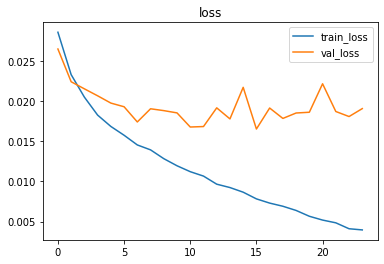

In [0]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.title('loss')

4.使用全部数据训练模型

In [0]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [0]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [0]:
num_epoch = 30
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    acc_train = 0.0
    loss_train = 0.0
    acc_val = 0.0
    loss_val = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # print(data[0].shape)
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        acc_train += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        loss_train += batch_loss.item()

    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' %
          epoch + 1, num_epoch, time.time() - epoch_start_time, cc_train / train_set.__len__(), loss_train / train_set.__len__())

5.test

In [0]:
test_set = ImgDataset(test_x, transforms = test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [0]:
model.eval()
pred = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model(data.cuda())
        test_label = np.argmax(test_pred.cpu().numpy, axis=1)
        for label in test_label:
            pred.append(label)

In [0]:
with open('subssion.csv', 'w') as f:
    f.write('Id,Category\n')
    for i, label in enumerate(pred):
        f.write('{},{}\n'.format(i, label))